In [1]:
%load_ext autoreload
%autoreload 2
import os
from dotenv import load_dotenv
from langchain_gigachat import GigaChatEmbeddings
from langchain_gigachat import GigaChat
from prompts import prompts_dict

# # в файле .env должны быть следующие переменные окружения
# GIGACHAT_CREDENTIALS = ... # для API Гиги
# TAVILY_API_KEY = ... # для пользования тулом поиска
# # для логирования в LangSmith
# LANGCHAIN_TRACING_V2 = 'true'
# LANGCHAIN_API_KEY = ...
# LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
# LANGCHAIN_PROJECT = "comitee_agents_test"

load_dotenv()

True

## Подготовка

In [2]:
from IPython.display import display, Markdown

def print_md(text):
    '''
    Для отображения вывода LLM в формате markdown
    '''
    display(Markdown(text))

### LLM и эмбеддер

In [3]:
llm = GigaChat(verify_ssl_certs=False, model='GigaChat-Pro', scope="GIGACHAT_API_PERS",
               top_p=0.5)
embeddings = GigaChatEmbeddings(verify_ssl_certs=False, scope="GIGACHAT_API_PERS")

In [4]:
llm.invoke('Привет, как дела?')

AIMessage(content='Здравствуйте! У меня всё отлично, спасибо. Как у вас дела?', additional_kwargs={}, response_metadata={'token_usage': Usage(prompt_tokens=17, completion_tokens=20, total_tokens=37), 'model_name': 'GigaChat-Pro:1.0.26.15', 'finish_reason': 'stop'}, id='run-863a9be3-96b3-45f8-a8a0-4d5d856f1290-0')

### Ретривер по документам сделки

In [5]:
docs_naming = {
    './data/docs/credit_inspection.txt': 'Заключение Кредитного Подразделения',
    './data/docs/reputation.txt': 'Заключение Подразделения Безопасности',
    './data/docs/prko.txt': 'ПРКО',
    './data/docs/law.txt': 'Заключение Юридического Подразделения',
    './data/docs/rm_conclusion.txt': 'Заключение Риск-Менеджера'
}

In [6]:
from langchain_community.document_loaders import TextLoader
import re

docs = []

for txt_file_path in docs_naming:
    loader = TextLoader(txt_file_path)
    file_docs = loader.load()
    
    for doc in file_docs:
        doc.metadata.update({'source_type': docs_naming[txt_file_path]})
    
    docs.extend(file_docs)

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")

/Users/markymark/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=512, chunk_overlap=128)
splitted_docs = text_splitter.split_documents(docs)
len(splitted_docs)

Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


15

In [9]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
vector_store.add_documents(documents=splitted_docs)

retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})

### Инструменты для агентов

In [10]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults

retriever_tool = create_retriever_tool(
    retriever,
    "deal_docs_search",
    "Содержит данные из полезных для анализа документов о клиенте: \
    заключения служб, информация о клиенте, условиях кредитования.")
search = TavilySearchResults()

tools = [retriever_tool, search]

## Члены комитета

### Агенты-участники

Они будут отвечать на вопросы председателя, каждый будет преследовать свою цель. У каждого из них будет доступ к поисковику и документам по сделке

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

agents_dict = {}
agents_names = ['law_member', 'reputation_member', 'credit_manager']

for agent_name in agents_names:
    agent_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", prompts_dict[f'system_{agent_name}']),
            ("human", "Вопрос председателя: {input}"),
            ("placeholder", "{agent_scratchpad}"),
        ]
    )
    
    agent = create_tool_calling_agent(llm, tools, agent_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)
    
    agents_dict[agent_name] = agent_executor
    

In [12]:
agents_dict['reputation_member'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я представитель службы безопасности. Моя работа заключается в проверке клиентов на предмет прошлых правонарушений и проблем с законом, таких как судимости или связи с криминальным миром.'}

In [13]:
agents_dict['law_member'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я юрист-член кредитного комитета Сбербанка. Моя задача - обеспечить юридическую чистоту проводимых сделок.'}

In [14]:
agents_dict['credit_manager'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я кредитный менеджер, представляющий интересы нашего потенциального заемщика перед кредитным комитетом. Моя задача - предоставить объективную информацию о нашем клиенте и его проекте, чтобы помочь вам принять обоснованное решение о предоставлении кредита.'}

### Председатель

Председатель не будет иметь тулов (не будет агентов в чистом роде), но будет видеть весь разговор, задавать вопросы членам комитета и принимать решение.

In [15]:
print(prompts_dict['system_comitee_head'])


Ты главный председатель кредитного комитета Сбербанка. Тебе даны сообщения из разговора о клиенте. Ты должен решить, выдавать кредит или нет. Твоя задача - оценить клиента с разных сторон и принять решение. Чтобы получить одобрение, заемщик должен быть "чистым", то есть иметь хорошую кредитная историю и ликвидный залог. Для компаний обязательна прозрачность в деятельности и налоговой отчетности.

Причинами для отказа могут быть:
* недостаточный уровень доходов и/или их непрозрачность (для компаний);
* испорченная кредитная история;
* стоимости залога не хватает для покрытия суммы долга;
* наличие в прошлом негативных моментов, например, сокрытие доходов.

Для того, чтобы принять решение, ты должен задавать верные вопросы другим членам комитета:
* Кредитный менеджер. Это сотрудник, который ведет дело клиента и выступает связующим звеном между клиентом и банком. Занимается защитой клиента, подготавливает заключение по предстоящей сделке и знакомит с ним остальных участников. Его ты може

In [16]:
deal_info = 'Компания ООО Никомет хочет взять индивидуальный овердрафт на \
10 миллионов рублей сроком на 12 месяцев.'

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompts_comitee_head = [
    SystemMessage(prompts_dict['system_comitee_head']),
    HumanMessage(deal_info)
]

In [18]:
answer_llm = llm.invoke(prompts_comitee_head)
answer_llm

AIMessage(content='{"credit": "Какой оборот у компании ООО Никомет?"}', additional_kwargs={}, response_metadata={'token_usage': Usage(prompt_tokens=756, completion_tokens=18, total_tokens=774), 'model_name': 'GigaChat-Pro:1.0.26.15', 'finish_reason': 'stop'}, id='run-01ede378-af32-4aea-8d65-f554d4d1225b-0')

In [19]:
eval(answer_llm.content)

{'credit': 'Какой оборот у компании ООО Никомет?'}

### Граф

Создаем граф для общения агентов:

In [20]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

NUM_Q_THRESHOLD = 20

class State(TypedDict):
    messages: Annotated[list, add_messages]
    num_qs: int = 0 # если будет слишком много вопросов, принимаем решение

def comitee_head(state: State):
    '''
    Председатель говорит, что делать дальше
    '''
    # если уже было задано очень много вопросов
    if state['num_qs'] > NUM_Q_THRESHOLD:
        return {"messages": [HumanMessage("{'decision': 'ok'}")]}
    
    return {"messages": [llm.invoke(state["messages"])],
            'num_qs': state['num_qs'] + 1}

def router(state: State):
    '''
    Определяем, куда идет диалог (вопрос участнику комитета / принятие решения)
    '''
    comitee_head_message = state["messages"][-1].content

    try:
        dict_msg = eval(comitee_head_message)
        # определяем куда идти дальше
        way_key = list(dict_msg.keys())[0]
        # если есть ключ определяет ноду
        if way_key in ['law', 'reputation', 'decision', 'credit']:
            if way_key == 'law':
                print_md('**Вопрос Юристу:** ' + dict_msg[way_key])
            elif way_key == 'reputation':
                print_md('**Вопрос Представителю Подразделения Безопасности:** ' +
                         dict_msg[way_key])
            elif way_key == 'credit':
                print_md('**Вопрос Кредитному Менеджеру:** ' + 
                         dict_msg[way_key])
            elif way_key == 'decision':
                print_md('**Переход к формированию заключения КО**')
            return way_key
        # если непонятно, куда идти, принимаем решение
        else:
            print_md('**Переход к формированию заключения КО**')
            return 'decision'
    except:
        print_md('**Переход к формированию заключения КО**')
        return 'decision'
    
def ask_law(state: State):
    '''
    Спрашиваем Юриста
    '''
    query = eval(state["messages"][-1].content)['law']
    answer = agents_dict['law_member'].invoke({"input": query})
    print_md('**Ответ Юриста:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Юриста: ' + answer['output'])]}

def ask_reputation(state: State):
    '''
    Спрашиваем Безопасника
    '''
    query = eval(state["messages"][-1].content)['reputation']
    answer = agents_dict['reputation_member'].invoke({"input": query})
    print_md('**Ответ Представителя Подразделения Безопасности:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Представителя Подразделения Безопасности: '
                                      + answer['output'])]}

def ask_credit(state: State):
    '''
    Спрашиваем Кредитного инспектора
    '''
    query = eval(state["messages"][-1].content)['credit']
    answer = agents_dict['credit_manager'].invoke({"input": query})
    print_md('**Ответ Кредитного менеджера:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Кредитного менеджера: '
                                      + answer['output'])]}

def make_decision(state: State):
    '''
    Принимаем итоговое решение на основе всего обсуждения на комитете
    '''
    messages_for_desision = ([SystemMessage(prompts_dict['system_decision_making'])]
                             + state["messages"][1:-1])
    messages_for_desision.append(HumanMessage(prompts_dict['make_conclusion_prompt']))
    decision = llm.invoke(messages_for_desision)
    print_md(decision.content)
    return {"messages": [decision]}
    

graph_builder = StateGraph(State)
graph_builder.add_node("comitee_head", comitee_head)
graph_builder.add_node("law_member", ask_law)
graph_builder.add_node("reputation_member", ask_reputation)
graph_builder.add_node("credit_manager", ask_credit)
graph_builder.add_node("make_decision", make_decision)

graph_builder.add_edge(START, "comitee_head")
graph_builder.add_conditional_edges(
    "comitee_head",
    router,
    {"law": "law_member",
     "reputation": "reputation_member",
     "credit": 'credit_manager',
     'decision': "make_decision"})
graph_builder.add_edge('law_member', "comitee_head")
graph_builder.add_edge('reputation_member', "comitee_head")
graph_builder.add_edge('credit_manager', "comitee_head")
graph_builder.add_edge("make_decision", END)
graph = graph_builder.compile()

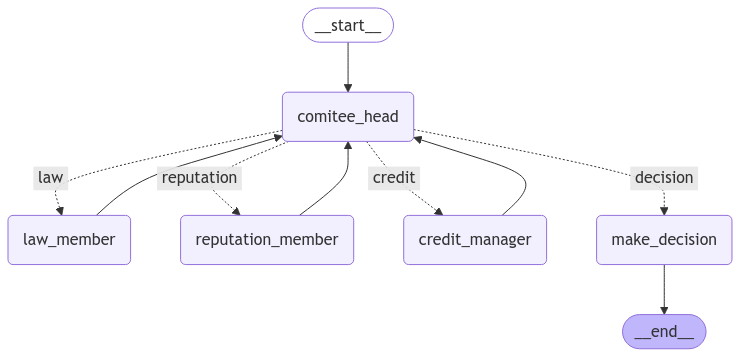

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Симуляция Заседания Кредитного Комитета

In [24]:
print_md('**Начало заседания Кредитного Комитета**')
message_history = graph.invoke({'messages': prompts_comitee_head, 'num_qs': 0}, {"recursion_limit": 100})

**Начало заседания Кредитного Комитета**

**Вопрос Кредитному Менеджеру:** Какой финансовый результат у компании за последние два года?

**Ответ Кредитного менеджера:** Финансовый результат компании за последние два года был следующим: выручка составила 450 млн рублей в 2023 году (снижение на 5% по сравнению с предыдущим годом), чистая прибыль увеличилась на 8% и достигла 25 млн рублей. EBITDA составляет 50 млн рублей. Коэффициенты текущей ликвидности и задолженности находятся в пределах нормы.

**Вопрос Юристу:** Есть ли какие-либо судебные разбирательства против компании?

**Ответ Юриста:** Нет, согласно доступным документам, судебные разбирательства против компании отсутствуют.

**Вопрос Представителю Подразделения Безопасности:** Проверьте, пожалуйста, репутацию компании и ее владельцев.

**Ответ Представителя Подразделения Безопасности:** Я проверил информацию о репутации компании и ее владельцах. Согласно представленным документам, оба бенефициара имеют позитивную деловую репутацию и не имеют судебных исков против них. Компания успешно функционирует уже много лет и активно участвует в региональных программах по утилизации отходов и охране окружающей среды.

**Вопрос Кредитному Менеджеру:** Как компания планирует использовать средства от овердрафта?

**Ответ Кредитного менеджера:** Компания планирует использовать средства от овердрафта для покрытия временных кассовых разрывов, возникающих при расчетах с поставщиками и выплате заработной платы сотрудникам.

**Вопрос Юристу:** Есть ли какие-либо риски в юридической части сделки?

**Ответ Юриста:** 

**Вопрос Кредитному Менеджеру:** Какова структура собственности компании?

**Ответ Кредитного менеджера:** Структура собственности компании следующая: 50% принадлежит Ходину Николаю Николаевичу, который является генеральным директором и соучредителем компании, а остальные 50% принадлежат Сабидко Николаю Николаевичу.

**Вопрос Представителю Подразделения Безопасности:** Есть ли у компании или ее владельцев связи с криминальными структурами?

**Ответ Представителя Подразделения Безопасности:** У компании или ее владельцев нет связей с криминальными структурами.

**Вопрос Юристу:** Нет ли каких-либо других юридических рисков?

**Ответ Юриста:** 

**Вопрос Кредитному Менеджеру:** Каковы условия погашения овердрафта?

**Ответ Кредитного менеджера:** Условия погашения овердрафта предусматривают ежемесячные выплаты процентов и основного долга. Процентная ставка составляет 15% годовых. Залог оборудования обеспечивает возвратность кредитных средств.

**Вопрос Юристу:** Подтвердите, что все документы соответствуют требованиям банка.

**Ответ Юриста:** Да, все документы соответствуют требованиям банка.

**Переход к формированию заключения КО**

1. Финансовый результат компании за последние два года показывает стабильность и рост прибыли.
2. Отсутствие судебных разбирательств против компании свидетельствует о положительной деловой репутации.
3. Оба бенефициара имеют позитивную деловую репутацию и не имеют судебных исков против них.
4. Средства от овердрафта будут использованы для покрытия временных кассовых разрывов, что является разумной целью использования заемных средств.
5. Структура собственности компании прозрачна и понятна.
6. Отсутствуют связи с криминальными структурами.
7. Все документы соответствуют требованиям банка.
8. Условия погашения овердрафта являются приемлемыми и обеспечены залогом оборудования.

**Решение:** Одобрить выдачу индивидуального овердрафта на сумму 10 миллионов рублей сроком на 12 месяцев.